In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
from keras.optimizers import SGD
from librosa.feature import chroma_stft
from librosa import load
from scipy.signal import fftconvolve
import numpy as np
import os
import matplotlib.pyplot as plt
from utils import mirex_evaluate, ks_template, inv_key_map

In [14]:
data_dim = 12
timesteps = 12
num_classes = 24

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(Conv2D(8, (5, 5), padding='same', input_shape=(timesteps, data_dim, 1), activation='relu')) #12
model.add(Conv2D(16, (5, 5), padding='valid', activation='relu'))  #8
model.add(Conv2D(32, (5, 5), padding='valid', activation='relu'))  #4
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 12, 12, 8)         208       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)          3216      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 32)          12832     
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1560      
Total para

In [15]:
sym2num = np.vectorize(inv_key_map.get)
evaluate_vec = np.vectorize(mirex_evaluate, otypes=[float])

train_set = [1, 3, 5, 11, 16, 19, 20, 22, 25, 26, 32]
val_set = [6, 13, 14, 21, 23, 31]
test_set = [8, 12, 18, 24, 27, 28]

data_dir = '/media/ycy/86A4D88BA4D87F5D/DataSet/BPS_piano'
ref_prefix = 'REF_key_'

In [16]:
train_data_list = []
train_target_list = []
val_data_list = []
val_target_list = []
test_data_list = []
test_target_list = []

w = 769
mean_filt = np.ones(w) / w

file_names = [".".join(f.split(".")[:-1]) for f in os.listdir(data_dir) if f[-4:] == '.wav']

for f in file_names:
    label = np.loadtxt(os.path.join(data_dir, ref_prefix + f + '.txt'), dtype='str')
    t = sym2num(label[:, 1])
    t2 = np.zeros((len(t), num_classes))
    t2[(np.arange(len(t)), t)] = 1

    data, sr = load(os.path.join(data_dir, f + '.wav'), sr=None)
    hop_size = int(sr / timesteps)
    window_size = hop_size * 2

    chroma_a = chroma_stft(y=data, sr=sr, hop_length=hop_size, n_fft=window_size, base_c=False)
    chroma_a = np.apply_along_axis(fftconvolve, 1, chroma_a, mean_filt, 'same')
    
    if chroma_a.shape[1] > len(t) * timesteps:
        chroma_a = chroma_a[:, :len(t) * timesteps]
    elif chroma_a.shape[1] < len(t) * timesteps:
        chroma_a = np.column_stack((chroma_a, np.zeros((data_dim, len(t) * timesteps - chroma_a.shape[1]))))
    chroma_a = chroma_a.T.reshape(-1, timesteps, data_dim)
    
    if int(f) in train_set:
        train_data_list.append(chroma_a)
        train_target_list.append(t2)
    elif int(f) in val_set:
        val_data_list.append(chroma_a)
        val_target_list.append(t2)
    else:
        test_data_list.append(chroma_a)
        test_target_list.append(t2)
    
    print(f, chroma_a.shape, t2.shape)

print(len(train_data_list), len(val_data_list), len(test_data_list))

32 (836, 12, 12) (836, 24)


1 (800, 12, 12) (800, 24)


11 (1068, 12, 12) (1068, 24)


12 (365, 12, 12) (365, 24)


13 (390, 12, 12) (390, 24)


14 (276, 12, 12) (276, 24)


16 (872, 12, 12) (872, 24)


18 (1024, 12, 12) (1024, 24)


19 (290, 12, 12) (290, 24)


20 (996, 12, 12) (996, 24)


21 (1554, 12, 12) (1554, 24)


22 (555, 12, 12) (555, 24)


23 (1669, 12, 12) (1669, 24)


24 (816, 12, 12) (816, 24)


25 (1116, 12, 12) (1116, 24)


26 (1200, 12, 12) (1200, 24)


27 (735, 12, 12) (735, 24)


28 (306, 12, 12) (306, 24)


3 (1390, 12, 12) (1390, 24)


31 (348, 12, 12) (348, 24)


5 (1438, 12, 12) (1438, 24)


6 (808, 12, 12) (808, 24)


8 (1728, 12, 12) (1728, 24)
11 6 6


In [17]:
train_data = np.concatenate(train_data_list)
train_target = np.concatenate(train_target_list)
val_data = np.concatenate(val_data_list)
val_target = np.concatenate(val_target_list)
test_data = np.concatenate(test_data_list)
test_target = np.concatenate(test_target_list)

train_data = np.expand_dims(train_data, axis=3)
val_data = np.expand_dims(val_data, axis=3)
test_data = np.expand_dims(test_data, axis=3)
print(train_data.shape)

(10561, 12, 12, 1)


In [18]:
history = model.fit(train_data, train_target, batch_size=128, epochs=20, validation_data=(val_data, val_target))

Train on 10561 samples, validate on 5045 samples
Epoch 1/20


  128/10561 [..............................] - ETA: 22s - loss: 3.1760 - acc: 0.0625

  256/10561 [..............................] - ETA: 13s - loss: 3.1728 - acc: 0.0703

  512/10561 [>.............................] - ETA: 8s - loss: 3.1686 - acc: 0.0781 

  768/10561 [=>............................] - ETA: 6s - loss: 3.1634 - acc: 0.0768

 1024/10561 [=>............................] - ETA: 4s - loss: 3.1551 - acc: 0.0898

 1280/10561 [==>...........................] - ETA: 4s - loss: 3.1470 - acc: 0.0906

 1536/10561 [===>..........................] - ETA: 3s - loss: 3.1347 - acc: 0.0964

 1792/10561 [====>.........................] - ETA: 3s - loss: 3.1224 - acc: 0.1032

 2176/10561 [=====>........................] - ETA: 2s - loss: 3.0906 - acc: 0.1089

 2560/10561 [======>.......................] - ETA: 2s - loss: 3.0492 - acc: 0.1109

 2944/10561 [=======>......................] - ETA: 2s - loss: 3.0055 - acc: 0.1141

 3328/10561 [========>.....................] - ETA: 2s - loss: 2.9609 - acc: 0.1208

 3584/10561 [=========>....................] - ETA: 1s - loss: 2.9433 - acc: 0.1233

 3968/10561 [==========>...................] - ETA: 1s - loss: 2.9123 - acc: 0.1230

 4352/10561 [===========>..................] - ETA: 1s - loss: 2.8886 - acc: 0.1229

 4608/10561 [============>.................] - ETA: 1s - loss: 2.8730 - acc: 0.1235

 4992/10561 [=============>................] - ETA: 1s - loss: 2.8526 - acc: 0.1264

 5376/10561 [==============>...............] - ETA: 1s - loss: 2.8341 - acc: 0.1319

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.8192 - acc: 0.1339

 6144/10561 [================>.............] - ETA: 1s - loss: 2.8070 - acc: 0.1356

 6528/10561 [=================>............] - ETA: 0s - loss: 2.7916 - acc: 0.1402

 6912/10561 [==================>...........] - ETA: 0s - loss: 2.7830 - acc: 0.1406

 7296/10561 [===================>..........] - ETA: 0s - loss: 2.7736 - acc: 0.1439

 7680/10561 [====================>.........] - ETA: 0s - loss: 2.7623 - acc: 0.1477

 8064/10561 [=====================>........] - ETA: 0s - loss: 2.7514 - acc: 0.1523

 8448/10561 [======================>.......] - ETA: 0s - loss: 2.7407 - acc: 0.1562

 8832/10561 [========================>.....] - ETA: 0s - loss: 2.7282 - acc: 0.1611

 9216/10561 [=========================>....] - ETA: 0s - loss: 2.7171 - acc: 0.1643

 9600/10561 [==========================>...] - ETA: 0s - loss: 2.7035 - acc: 0.1702

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.6886 - acc: 0.1756

10368/10561 [============================>.] - ETA: 0s - loss: 2.6726 - acc: 0.1802

10561/10561 [==============================] - 2s 228us/step - loss: 2.6647 - acc: 0.1829 - val_loss: 3.1869 - val_acc: 0.1171


Epoch 2/20
  128/10561 [..............................] - ETA: 2s - loss: 2.2426 - acc: 0.3203

  512/10561 [>.............................] - ETA: 1s - loss: 2.1853 - acc: 0.3672

  896/10561 [=>............................] - ETA: 1s - loss: 2.1030 - acc: 0.3873

 1280/10561 [==>...........................] - ETA: 1s - loss: 2.1025 - acc: 0.3727

 1664/10561 [===>..........................] - ETA: 1s - loss: 2.0752 - acc: 0.3732

 2048/10561 [====>.........................] - ETA: 1s - loss: 2.0597 - acc: 0.3813

 2432/10561 [=====>........................] - ETA: 1s - loss: 2.0408 - acc: 0.3882

 2816/10561 [======>.......................] - ETA: 1s - loss: 2.0032 - acc: 0.3977

 3200/10561 [========>.....................] - ETA: 1s - loss: 1.9665 - acc: 0.4088

 3584/10561 [=========>....................] - ETA: 1s - loss: 1.9426 - acc: 0.4146

 3968/10561 [==========>...................] - ETA: 1s - loss: 1.9106 - acc: 0.4231

 4352/10561 [===========>..................] - ETA: 1s - loss: 1.8828 - acc: 0.4343

 4736/10561 [============>.................] - ETA: 0s - loss: 1.8501 - acc: 0.4438

 5120/10561 [=============>................] - ETA: 0s - loss: 1.8112 - acc: 0.4553

 5504/10561 [==============>...............] - ETA: 0s - loss: 1.7846 - acc: 0.4666

 5888/10561 [===============>..............] - ETA: 0s - loss: 1.7526 - acc: 0.4766

 6272/10561 [================>.............] - ETA: 0s - loss: 1.7377 - acc: 0.4817

 6656/10561 [=================>............] - ETA: 0s - loss: 1.7145 - acc: 0.4884

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.6894 - acc: 0.4966

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.6717 - acc: 0.5035

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.6492 - acc: 0.5111

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.6334 - acc: 0.5161

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.6160 - acc: 0.5208

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.6010 - acc: 0.5251

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.5854 - acc: 0.5302

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.5737 - acc: 0.5334

10112/10561 [===========================>..] - ETA: 0s - loss: 1.5593 - acc: 0.5380

10496/10561 [============================>.] - ETA: 0s - loss: 1.5425 - acc: 0.5425

10561/10561 [==============================] - 2s 181us/step - loss: 1.5405 - acc: 0.5433 - val_loss: 2.9636 - val_acc: 0.4036


Epoch 3/20
  128/10561 [..............................] - ETA: 1s - loss: 1.0469 - acc: 0.6797

  512/10561 [>.............................] - ETA: 1s - loss: 1.0930 - acc: 0.6621

  896/10561 [=>............................] - ETA: 1s - loss: 1.1436 - acc: 0.6473

 1280/10561 [==>...........................] - ETA: 1s - loss: 1.1331 - acc: 0.6633

 1664/10561 [===>..........................] - ETA: 1s - loss: 1.1344 - acc: 0.6629

 2048/10561 [====>.........................] - ETA: 1s - loss: 1.1163 - acc: 0.6621

 2432/10561 [=====>........................] - ETA: 1s - loss: 1.1270 - acc: 0.6575

 2816/10561 [======>.......................] - ETA: 1s - loss: 1.1138 - acc: 0.6609

 3200/10561 [========>.....................] - ETA: 1s - loss: 1.1129 - acc: 0.6616

 3584/10561 [=========>....................] - ETA: 1s - loss: 1.1080 - acc: 0.6602

 3968/10561 [==========>...................] - ETA: 1s - loss: 1.1039 - acc: 0.6620

 4352/10561 [===========>..................] - ETA: 0s - loss: 1.1028 - acc: 0.6620

 4736/10561 [============>.................] - ETA: 0s - loss: 1.0983 - acc: 0.6624

 5120/10561 [=============>................] - ETA: 0s - loss: 1.0950 - acc: 0.6641

 5504/10561 [==============>...............] - ETA: 0s - loss: 1.0884 - acc: 0.6662

 5888/10561 [===============>..............] - ETA: 0s - loss: 1.0832 - acc: 0.6654

 6272/10561 [================>.............] - ETA: 0s - loss: 1.0816 - acc: 0.6653

 6656/10561 [=================>............] - ETA: 0s - loss: 1.0805 - acc: 0.6638

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.0757 - acc: 0.6659

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.0696 - acc: 0.6670

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.0713 - acc: 0.6652

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.0678 - acc: 0.6653

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.0757 - acc: 0.6624

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.0751 - acc: 0.6623

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.0701 - acc: 0.6628

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.0656 - acc: 0.6639

10112/10561 [===========================>..] - ETA: 0s - loss: 1.0601 - acc: 0.6652

10496/10561 [============================>.] - ETA: 0s - loss: 1.0570 - acc: 0.6667

10561/10561 [==============================] - 2s 177us/step - loss: 1.0572 - acc: 0.6667 - val_loss: 2.9520 - val_acc: 0.4333


Epoch 4/20
  128/10561 [..............................] - ETA: 1s - loss: 0.8728 - acc: 0.7031

  512/10561 [>.............................] - ETA: 1s - loss: 0.9855 - acc: 0.6602

  896/10561 [=>............................] - ETA: 1s - loss: 0.9582 - acc: 0.6708

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.9644 - acc: 0.6727

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.9500 - acc: 0.6809

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.9395 - acc: 0.6816

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.9307 - acc: 0.6854

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.9278 - acc: 0.6847

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.9319 - acc: 0.6866

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.9333 - acc: 0.6855

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.9311 - acc: 0.6852

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.9228 - acc: 0.6866

 4736/10561 [============>.................] - ETA: 0s - loss: 0.9284 - acc: 0.6869

 5120/10561 [=============>................] - ETA: 0s - loss: 0.9319 - acc: 0.6875

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.9364 - acc: 0.6846

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.9333 - acc: 0.6861

 6272/10561 [================>.............] - ETA: 0s - loss: 0.9291 - acc: 0.6865

 6656/10561 [=================>............] - ETA: 0s - loss: 0.9219 - acc: 0.6890

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.9242 - acc: 0.6879

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.9296 - acc: 0.6851

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.9269 - acc: 0.6862

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.9227 - acc: 0.6888

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.9214 - acc: 0.6891

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.9240 - acc: 0.6883

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.9250 - acc: 0.6893

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.9209 - acc: 0.6909

10112/10561 [===========================>..] - ETA: 0s - loss: 0.9180 - acc: 0.6918

10496/10561 [============================>.] - ETA: 0s - loss: 0.9201 - acc: 0.6905

10561/10561 [==============================] - 2s 176us/step - loss: 0.9206 - acc: 0.6900 - val_loss: 3.0340 - val_acc: 0.4466


Epoch 5/20
  128/10561 [..............................] - ETA: 1s - loss: 0.7795 - acc: 0.7109

  512/10561 [>.............................] - ETA: 1s - loss: 0.8154 - acc: 0.7090

  896/10561 [=>............................] - ETA: 1s - loss: 0.7933 - acc: 0.7299

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.8069 - acc: 0.7266

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.8079 - acc: 0.7248

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.8189 - acc: 0.7192

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.8140 - acc: 0.7212

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.8262 - acc: 0.7148

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.8214 - acc: 0.7166

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.8174 - acc: 0.7162

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.8190 - acc: 0.7185

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.8252 - acc: 0.7181

 4736/10561 [============>.................] - ETA: 0s - loss: 0.8282 - acc: 0.7192

 5120/10561 [=============>................] - ETA: 0s - loss: 0.8375 - acc: 0.7148

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.8493 - acc: 0.7106

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.8470 - acc: 0.7113

 6272/10561 [================>.............] - ETA: 0s - loss: 0.8459 - acc: 0.7108

 6656/10561 [=================>............] - ETA: 0s - loss: 0.8440 - acc: 0.7132

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.8430 - acc: 0.7126

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.8456 - acc: 0.7121

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.8434 - acc: 0.7139

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.8445 - acc: 0.7133

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.8422 - acc: 0.7132

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.8396 - acc: 0.7124

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.8381 - acc: 0.7125

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.8403 - acc: 0.7113

10112/10561 [===========================>..] - ETA: 0s - loss: 0.8380 - acc: 0.7113

10496/10561 [============================>.] - ETA: 0s - loss: 0.8351 - acc: 0.7120

10561/10561 [==============================] - 2s 178us/step - loss: 0.8335 - acc: 0.7124 - val_loss: 3.3153 - val_acc: 0.4165


Epoch 6/20
  128/10561 [..............................] - ETA: 1s - loss: 0.9250 - acc: 0.7031

  512/10561 [>.............................] - ETA: 1s - loss: 0.7436 - acc: 0.7363

  896/10561 [=>............................] - ETA: 1s - loss: 0.7455 - acc: 0.7377

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.7684 - acc: 0.7305

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.7483 - acc: 0.7392

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.7691 - acc: 0.7354

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.7828 - acc: 0.7331

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.7772 - acc: 0.7326

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.7833 - acc: 0.7278

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.7849 - acc: 0.7282

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.7875 - acc: 0.7286

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.7843 - acc: 0.7284

 4736/10561 [============>.................] - ETA: 0s - loss: 0.7797 - acc: 0.7283

 5120/10561 [=============>................] - ETA: 0s - loss: 0.7867 - acc: 0.7264

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.7845 - acc: 0.7275

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.7825 - acc: 0.7291

 6272/10561 [================>.............] - ETA: 0s - loss: 0.7784 - acc: 0.7302

 6656/10561 [=================>............] - ETA: 0s - loss: 0.7795 - acc: 0.7303

 6912/10561 [==================>...........] - ETA: 0s - loss: 0.7791 - acc: 0.7300

 7296/10561 [===================>..........] - ETA: 0s - loss: 0.7775 - acc: 0.7309

 7680/10561 [====================>.........] - ETA: 0s - loss: 0.7775 - acc: 0.7318

 8064/10561 [=====================>........] - ETA: 0s - loss: 0.7780 - acc: 0.7321

 8448/10561 [======================>.......] - ETA: 0s - loss: 0.7759 - acc: 0.7325

 8832/10561 [========================>.....] - ETA: 0s - loss: 0.7788 - acc: 0.7300

 9216/10561 [=========================>....] - ETA: 0s - loss: 0.7797 - acc: 0.7299

 9600/10561 [==========================>...] - ETA: 0s - loss: 0.7776 - acc: 0.7296

 9984/10561 [===========================>..] - ETA: 0s - loss: 0.7712 - acc: 0.7321

10368/10561 [============================>.] - ETA: 0s - loss: 0.7721 - acc: 0.7319

10561/10561 [==============================] - 2s 179us/step - loss: 0.7703 - acc: 0.7324 - val_loss: 3.5658 - val_acc: 0.4034


Epoch 7/20
  128/10561 [..............................] - ETA: 1s - loss: 0.6630 - acc: 0.7578

  512/10561 [>.............................] - ETA: 1s - loss: 0.7320 - acc: 0.7246

  896/10561 [=>............................] - ETA: 1s - loss: 0.7191 - acc: 0.7232

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.7422 - acc: 0.7266

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.7409 - acc: 0.7332

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.7339 - acc: 0.7378

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.7167 - acc: 0.7447

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.7125 - acc: 0.7464

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.7102 - acc: 0.7472

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.7148 - acc: 0.7464

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.7174 - acc: 0.7472

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.7224 - acc: 0.7463

 4736/10561 [============>.................] - ETA: 0s - loss: 0.7265 - acc: 0.7451

 5120/10561 [=============>................] - ETA: 0s - loss: 0.7273 - acc: 0.7439

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.7210 - acc: 0.7455

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.7200 - acc: 0.7451

 6272/10561 [================>.............] - ETA: 0s - loss: 0.7188 - acc: 0.7451

 6656/10561 [=================>............] - ETA: 0s - loss: 0.7197 - acc: 0.7450

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.7198 - acc: 0.7450

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.7186 - acc: 0.7454

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.7222 - acc: 0.7440

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.7210 - acc: 0.7438

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.7214 - acc: 0.7437

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.7196 - acc: 0.7438

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.7222 - acc: 0.7426

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.7220 - acc: 0.7439

10112/10561 [===========================>..] - ETA: 0s - loss: 0.7188 - acc: 0.7444

10496/10561 [============================>.] - ETA: 0s - loss: 0.7183 - acc: 0.7449

10561/10561 [==============================] - 2s 176us/step - loss: 0.7183 - acc: 0.7451 - val_loss: 3.8639 - val_acc: 0.3707


Epoch 8/20
  128/10561 [..............................] - ETA: 1s - loss: 0.5765 - acc: 0.7969

  512/10561 [>.............................] - ETA: 1s - loss: 0.6930 - acc: 0.7559

  896/10561 [=>............................] - ETA: 1s - loss: 0.7361 - acc: 0.7355

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.7229 - acc: 0.7398

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.7148 - acc: 0.7386

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.7020 - acc: 0.7422

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.6983 - acc: 0.7414

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.7021 - acc: 0.7425

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.6950 - acc: 0.7450

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.6930 - acc: 0.7461

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.6985 - acc: 0.7460

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.6919 - acc: 0.7495

 4736/10561 [============>.................] - ETA: 0s - loss: 0.6899 - acc: 0.7487

 5120/10561 [=============>................] - ETA: 0s - loss: 0.6902 - acc: 0.7471

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.6876 - acc: 0.7482

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.6859 - acc: 0.7488

 6272/10561 [================>.............] - ETA: 0s - loss: 0.6836 - acc: 0.7506

 6656/10561 [=================>............] - ETA: 0s - loss: 0.6887 - acc: 0.7498

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.6859 - acc: 0.7497

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.6871 - acc: 0.7495

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.6853 - acc: 0.7510

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.6870 - acc: 0.7501

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.6830 - acc: 0.7514

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.6796 - acc: 0.7530

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.6775 - acc: 0.7530

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.6774 - acc: 0.7525

10112/10561 [===========================>..] - ETA: 0s - loss: 0.6763 - acc: 0.7521

10496/10561 [============================>.] - ETA: 0s - loss: 0.6732 - acc: 0.7530

10561/10561 [==============================] - 2s 178us/step - loss: 0.6735 - acc: 0.7529 - val_loss: 3.8915 - val_acc: 0.3899


Epoch 9/20
  128/10561 [..............................] - ETA: 1s - loss: 0.4983 - acc: 0.7969

  512/10561 [>.............................] - ETA: 1s - loss: 0.6437 - acc: 0.7695

  896/10561 [=>............................] - ETA: 1s - loss: 0.6642 - acc: 0.7578

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.6534 - acc: 0.7578

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.6672 - acc: 0.7530

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.6503 - acc: 0.7632

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.6498 - acc: 0.7632

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.6472 - acc: 0.7649

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.6476 - acc: 0.7653

 3456/10561 [========>.....................] - ETA: 1s - loss: 0.6510 - acc: 0.7648

 3712/10561 [=========>....................] - ETA: 1s - loss: 0.6519 - acc: 0.7637

 4096/10561 [==========>...................] - ETA: 1s - loss: 0.6485 - acc: 0.7622

 4480/10561 [===========>..................] - ETA: 1s - loss: 0.6504 - acc: 0.7609

 4864/10561 [============>.................] - ETA: 0s - loss: 0.6458 - acc: 0.7625

 5248/10561 [=============>................] - ETA: 0s - loss: 0.6406 - acc: 0.7654

 5632/10561 [==============>...............] - ETA: 0s - loss: 0.6428 - acc: 0.7646

 6016/10561 [================>.............] - ETA: 0s - loss: 0.6448 - acc: 0.7650

 6400/10561 [=================>............] - ETA: 0s - loss: 0.6458 - acc: 0.7645

 6784/10561 [==================>...........] - ETA: 0s - loss: 0.6466 - acc: 0.7631

 7168/10561 [===================>..........] - ETA: 0s - loss: 0.6435 - acc: 0.7646

 7552/10561 [====================>.........] - ETA: 0s - loss: 0.6435 - acc: 0.7642

 7936/10561 [=====================>........] - ETA: 0s - loss: 0.6444 - acc: 0.7637

 8320/10561 [======================>.......] - ETA: 0s - loss: 0.6424 - acc: 0.7651

 8704/10561 [=======================>......] - ETA: 0s - loss: 0.6414 - acc: 0.7659

 9088/10561 [========================>.....] - ETA: 0s - loss: 0.6413 - acc: 0.7655

 9472/10561 [=========================>....] - ETA: 0s - loss: 0.6406 - acc: 0.7662

 9856/10561 [==========================>...] - ETA: 0s - loss: 0.6372 - acc: 0.7671

10240/10561 [============================>.] - ETA: 0s - loss: 0.6367 - acc: 0.7683

10561/10561 [==============================] - 2s 182us/step - loss: 0.6366 - acc: 0.7678 - val_loss: 4.4114 - val_acc: 0.3857


Epoch 10/20
  128/10561 [..............................] - ETA: 1s - loss: 0.6208 - acc: 0.7812

  512/10561 [>.............................] - ETA: 1s - loss: 0.6338 - acc: 0.7715

  896/10561 [=>............................] - ETA: 1s - loss: 0.5963 - acc: 0.7779

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.5949 - acc: 0.7734

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.6056 - acc: 0.7722

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.6057 - acc: 0.7695

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.5978 - acc: 0.7730

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.6031 - acc: 0.7734

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.6256 - acc: 0.7662

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.6245 - acc: 0.7673

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.6258 - acc: 0.7659

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.6351 - acc: 0.7622

 4736/10561 [============>.................] - ETA: 0s - loss: 0.6340 - acc: 0.7627

 5120/10561 [=============>................] - ETA: 0s - loss: 0.6384 - acc: 0.7619

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.6304 - acc: 0.7653

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.6297 - acc: 0.7658

 6272/10561 [================>.............] - ETA: 0s - loss: 0.6275 - acc: 0.7674

 6656/10561 [=================>............] - ETA: 0s - loss: 0.6260 - acc: 0.7680

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.6235 - acc: 0.7692

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.6273 - acc: 0.7672

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.6288 - acc: 0.7660

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.6282 - acc: 0.7661

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.6266 - acc: 0.7655

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.6254 - acc: 0.7656

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.6229 - acc: 0.7669

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.6262 - acc: 0.7661

10112/10561 [===========================>..] - ETA: 0s - loss: 0.6251 - acc: 0.7663

10496/10561 [============================>.] - ETA: 0s - loss: 0.6214 - acc: 0.7671

10561/10561 [==============================] - 2s 177us/step - loss: 0.6203 - acc: 0.7677 - val_loss: 4.3967 - val_acc: 0.3625


Epoch 11/20
  128/10561 [..............................] - ETA: 1s - loss: 0.6152 - acc: 0.7734

  512/10561 [>.............................] - ETA: 1s - loss: 0.6127 - acc: 0.7832

  896/10561 [=>............................] - ETA: 1s - loss: 0.6135 - acc: 0.7723

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.6060 - acc: 0.7773

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.5925 - acc: 0.7776

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.5939 - acc: 0.7749

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.5781 - acc: 0.7812

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.5735 - acc: 0.7844

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.5708 - acc: 0.7881

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.5801 - acc: 0.7854

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.5774 - acc: 0.7863

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.5785 - acc: 0.7858

 4736/10561 [============>.................] - ETA: 0s - loss: 0.5778 - acc: 0.7870

 5120/10561 [=============>................] - ETA: 0s - loss: 0.5740 - acc: 0.7869

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.5748 - acc: 0.7865

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.5729 - acc: 0.7872

 6272/10561 [================>.............] - ETA: 0s - loss: 0.5746 - acc: 0.7859

 6656/10561 [=================>............] - ETA: 0s - loss: 0.5760 - acc: 0.7852

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.5799 - acc: 0.7837

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.5788 - acc: 0.7839

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.5777 - acc: 0.7839

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.5771 - acc: 0.7838

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.5750 - acc: 0.7837

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.5771 - acc: 0.7826

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.5769 - acc: 0.7825

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.5771 - acc: 0.7826

10112/10561 [===========================>..] - ETA: 0s - loss: 0.5783 - acc: 0.7809

10496/10561 [============================>.] - ETA: 0s - loss: 0.5774 - acc: 0.7819

10561/10561 [==============================] - 2s 175us/step - loss: 0.5783 - acc: 0.7816 - val_loss: 4.6884 - val_acc: 0.3865


Epoch 12/20
  128/10561 [..............................] - ETA: 1s - loss: 0.6131 - acc: 0.7734

  512/10561 [>.............................] - ETA: 1s - loss: 0.5788 - acc: 0.7617

  896/10561 [=>............................] - ETA: 1s - loss: 0.5631 - acc: 0.7846

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.5536 - acc: 0.7852

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.5625 - acc: 0.7819

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.5656 - acc: 0.7793

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.5771 - acc: 0.7780

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.5768 - acc: 0.7795

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.5698 - acc: 0.7809

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.5693 - acc: 0.7796

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.5662 - acc: 0.7815

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.5658 - acc: 0.7815

 4736/10561 [============>.................] - ETA: 0s - loss: 0.5693 - acc: 0.7800

 5120/10561 [=============>................] - ETA: 0s - loss: 0.5651 - acc: 0.7840

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.5675 - acc: 0.7840

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.5698 - acc: 0.7836

 6272/10561 [================>.............] - ETA: 0s - loss: 0.5725 - acc: 0.7819

 6656/10561 [=================>............] - ETA: 0s - loss: 0.5734 - acc: 0.7825

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.5704 - acc: 0.7839

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.5688 - acc: 0.7834

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.5700 - acc: 0.7832

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.5712 - acc: 0.7830

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.5692 - acc: 0.7832

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.5674 - acc: 0.7840

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.5627 - acc: 0.7852

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.5648 - acc: 0.7843

10112/10561 [===========================>..] - ETA: 0s - loss: 0.5630 - acc: 0.7852

10496/10561 [============================>.] - ETA: 0s - loss: 0.5658 - acc: 0.7843

10561/10561 [==============================] - 2s 178us/step - loss: 0.5667 - acc: 0.7839 - val_loss: 4.7052 - val_acc: 0.3703


Epoch 13/20
  128/10561 [..............................] - ETA: 1s - loss: 0.4717 - acc: 0.8359

  512/10561 [>.............................] - ETA: 1s - loss: 0.5886 - acc: 0.7734

  896/10561 [=>............................] - ETA: 1s - loss: 0.5698 - acc: 0.7790

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.5778 - acc: 0.7805

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.5813 - acc: 0.7806

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.5685 - acc: 0.7876

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.5580 - acc: 0.7936

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.5578 - acc: 0.7912

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.5533 - acc: 0.7894

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.5533 - acc: 0.7885

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.5546 - acc: 0.7881

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.5495 - acc: 0.7895

 4736/10561 [============>.................] - ETA: 0s - loss: 0.5514 - acc: 0.7874

 5120/10561 [=============>................] - ETA: 0s - loss: 0.5495 - acc: 0.7871

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.5568 - acc: 0.7832

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.5569 - acc: 0.7840

 6272/10561 [================>.............] - ETA: 0s - loss: 0.5554 - acc: 0.7846

 6656/10561 [=================>............] - ETA: 0s - loss: 0.5542 - acc: 0.7858

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.5523 - acc: 0.7864

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.5498 - acc: 0.7883

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.5462 - acc: 0.7903

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.5474 - acc: 0.7896

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.5474 - acc: 0.7899

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.5487 - acc: 0.7884

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.5522 - acc: 0.7869

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.5503 - acc: 0.7872

10112/10561 [===========================>..] - ETA: 0s - loss: 0.5487 - acc: 0.7876

10496/10561 [============================>.] - ETA: 0s - loss: 0.5482 - acc: 0.7873

10561/10561 [==============================] - 2s 179us/step - loss: 0.5476 - acc: 0.7872 - val_loss: 5.0490 - val_acc: 0.3308


Epoch 14/20
  128/10561 [..............................] - ETA: 1s - loss: 0.5402 - acc: 0.7734

  512/10561 [>.............................] - ETA: 1s - loss: 0.5294 - acc: 0.7891

  896/10561 [=>............................] - ETA: 1s - loss: 0.4947 - acc: 0.8069

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.5080 - acc: 0.8063

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.5074 - acc: 0.8047

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.5142 - acc: 0.8013

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.5190 - acc: 0.7977

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.5172 - acc: 0.8008

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.5265 - acc: 0.7966

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.5261 - acc: 0.7966

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.5227 - acc: 0.8012

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.5237 - acc: 0.7992

 4736/10561 [============>.................] - ETA: 0s - loss: 0.5170 - acc: 0.8007

 5120/10561 [=============>................] - ETA: 0s - loss: 0.5135 - acc: 0.8020

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.5157 - acc: 0.8014

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.5201 - acc: 0.7999

 6272/10561 [================>.............] - ETA: 0s - loss: 0.5194 - acc: 0.7994

 6656/10561 [=================>............] - ETA: 0s - loss: 0.5196 - acc: 0.7982

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.5186 - acc: 0.7990

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.5215 - acc: 0.7978

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.5215 - acc: 0.7978

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.5227 - acc: 0.7975

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.5239 - acc: 0.7968

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.5241 - acc: 0.7962

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.5249 - acc: 0.7953

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.5229 - acc: 0.7967

10112/10561 [===========================>..] - ETA: 0s - loss: 0.5224 - acc: 0.7967

10496/10561 [============================>.] - ETA: 0s - loss: 0.5231 - acc: 0.7959

10561/10561 [==============================] - 2s 179us/step - loss: 0.5236 - acc: 0.7960 - val_loss: 5.2802 - val_acc: 0.3302


Epoch 15/20
  128/10561 [..............................] - ETA: 1s - loss: 0.5361 - acc: 0.7734

  512/10561 [>.............................] - ETA: 1s - loss: 0.5362 - acc: 0.7578

  896/10561 [=>............................] - ETA: 1s - loss: 0.5338 - acc: 0.7679

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.4907 - acc: 0.7875

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.4920 - acc: 0.7933

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.4946 - acc: 0.7969

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.4909 - acc: 0.8010

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.5017 - acc: 0.8004

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.5017 - acc: 0.7997

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.5052 - acc: 0.7952

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.5100 - acc: 0.7928

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.5050 - acc: 0.7941

 4736/10561 [============>.................] - ETA: 0s - loss: 0.5054 - acc: 0.7922

 5120/10561 [=============>................] - ETA: 0s - loss: 0.5063 - acc: 0.7920

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.5131 - acc: 0.7909

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.5140 - acc: 0.7904

 6272/10561 [================>.............] - ETA: 0s - loss: 0.5117 - acc: 0.7918

 6656/10561 [=================>............] - ETA: 0s - loss: 0.5105 - acc: 0.7924

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.5103 - acc: 0.7925

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.5118 - acc: 0.7928

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.5112 - acc: 0.7928

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.5104 - acc: 0.7938

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.5128 - acc: 0.7924

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.5119 - acc: 0.7936

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.5101 - acc: 0.7944

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.5068 - acc: 0.7966

10112/10561 [===========================>..] - ETA: 0s - loss: 0.5077 - acc: 0.7959

10496/10561 [============================>.] - ETA: 0s - loss: 0.5096 - acc: 0.7950

10561/10561 [==============================] - 2s 177us/step - loss: 0.5095 - acc: 0.7951 - val_loss: 5.2976 - val_acc: 0.3510


Epoch 16/20
  128/10561 [..............................] - ETA: 1s - loss: 0.3546 - acc: 0.8594

  512/10561 [>.............................] - ETA: 1s - loss: 0.4623 - acc: 0.8008

  896/10561 [=>............................] - ETA: 1s - loss: 0.4737 - acc: 0.8036

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.4876 - acc: 0.8023

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.4860 - acc: 0.8011

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.4914 - acc: 0.7998

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.5057 - acc: 0.7965

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.5022 - acc: 0.7983

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.4971 - acc: 0.8003

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.4935 - acc: 0.8016

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.5012 - acc: 0.7989

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.4994 - acc: 0.7996

 4736/10561 [============>.................] - ETA: 0s - loss: 0.5026 - acc: 0.7996

 5120/10561 [=============>................] - ETA: 0s - loss: 0.5030 - acc: 0.8000

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.4993 - acc: 0.8011

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.4990 - acc: 0.8023

 6272/10561 [================>.............] - ETA: 0s - loss: 0.4997 - acc: 0.8021

 6656/10561 [=================>............] - ETA: 0s - loss: 0.5007 - acc: 0.8009

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.5021 - acc: 0.8004

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.5032 - acc: 0.8001

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.5014 - acc: 0.8001

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.5022 - acc: 0.7992

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.5041 - acc: 0.7982

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.5045 - acc: 0.7988

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.5026 - acc: 0.7994

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.5040 - acc: 0.7993

10112/10561 [===========================>..] - ETA: 0s - loss: 0.5034 - acc: 0.8000

10496/10561 [============================>.] - ETA: 0s - loss: 0.5021 - acc: 0.7996

10561/10561 [==============================] - 2s 178us/step - loss: 0.5018 - acc: 0.7999 - val_loss: 5.3303 - val_acc: 0.3598


Epoch 17/20
  128/10561 [..............................] - ETA: 1s - loss: 0.4831 - acc: 0.8125

  512/10561 [>.............................] - ETA: 1s - loss: 0.5022 - acc: 0.8105

  896/10561 [=>............................] - ETA: 1s - loss: 0.4970 - acc: 0.8158

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.4782 - acc: 0.8211

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.4715 - acc: 0.8197

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.4792 - acc: 0.8169

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.4779 - acc: 0.8195

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.4821 - acc: 0.8161

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.4794 - acc: 0.8178

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.4821 - acc: 0.8133

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.4771 - acc: 0.8145

 4352/10561 [===========>..................] - ETA: 1s - loss: 0.4776 - acc: 0.8132

 4736/10561 [============>.................] - ETA: 0s - loss: 0.4818 - acc: 0.8108

 5120/10561 [=============>................] - ETA: 0s - loss: 0.4813 - acc: 0.8090

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.4891 - acc: 0.8067

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.4895 - acc: 0.8066

 6272/10561 [================>.............] - ETA: 0s - loss: 0.4927 - acc: 0.8048

 6656/10561 [=================>............] - ETA: 0s - loss: 0.4917 - acc: 0.8048

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.4915 - acc: 0.8060

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.4901 - acc: 0.8052

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.4866 - acc: 0.8056

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.4841 - acc: 0.8064

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.4840 - acc: 0.8056

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.4829 - acc: 0.8067

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.4814 - acc: 0.8071

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.4805 - acc: 0.8077

10112/10561 [===========================>..] - ETA: 0s - loss: 0.4819 - acc: 0.8079

10496/10561 [============================>.] - ETA: 0s - loss: 0.4801 - acc: 0.8083

10561/10561 [==============================] - 2s 180us/step - loss: 0.4792 - acc: 0.8088 - val_loss: 5.2778 - val_acc: 0.3697


Epoch 18/20
  128/10561 [..............................] - ETA: 1s - loss: 0.5813 - acc: 0.7734

  512/10561 [>.............................] - ETA: 1s - loss: 0.4996 - acc: 0.7969

  896/10561 [=>............................] - ETA: 1s - loss: 0.5013 - acc: 0.7980

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.4851 - acc: 0.8039

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.4777 - acc: 0.8059

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.4649 - acc: 0.8101

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.4650 - acc: 0.8100

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.4748 - acc: 0.8086

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.4796 - acc: 0.8069

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.4739 - acc: 0.8080

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.4687 - acc: 0.8112

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.4641 - acc: 0.8139

 4736/10561 [============>.................] - ETA: 0s - loss: 0.4645 - acc: 0.8146

 5120/10561 [=============>................] - ETA: 0s - loss: 0.4672 - acc: 0.8137

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.4647 - acc: 0.8136

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.4673 - acc: 0.8128

 6272/10561 [================>.............] - ETA: 0s - loss: 0.4692 - acc: 0.8122

 6656/10561 [=================>............] - ETA: 0s - loss: 0.4686 - acc: 0.8134

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.4672 - acc: 0.8136

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.4687 - acc: 0.8136

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.4690 - acc: 0.8125

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.4699 - acc: 0.8119

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.4731 - acc: 0.8102

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.4743 - acc: 0.8096

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.4743 - acc: 0.8095

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.4752 - acc: 0.8096

10112/10561 [===========================>..] - ETA: 0s - loss: 0.4771 - acc: 0.8087

10496/10561 [============================>.] - ETA: 0s - loss: 0.4771 - acc: 0.8084

10561/10561 [==============================] - 2s 177us/step - loss: 0.4774 - acc: 0.8084 - val_loss: 5.4728 - val_acc: 0.3764


Epoch 19/20
  128/10561 [..............................] - ETA: 3s - loss: 0.4679 - acc: 0.8047

  256/10561 [..............................] - ETA: 4s - loss: 0.4286 - acc: 0.8125

  512/10561 [>.............................] - ETA: 3s - loss: 0.4307 - acc: 0.8164

  768/10561 [=>............................] - ETA: 3s - loss: 0.4679 - acc: 0.8086

  896/10561 [=>............................] - ETA: 3s - loss: 0.4738 - acc: 0.8080

 1152/10561 [==>...........................] - ETA: 3s - loss: 0.4859 - acc: 0.8064

 1536/10561 [===>..........................] - ETA: 2s - loss: 0.4857 - acc: 0.8066

 1920/10561 [====>.........................] - ETA: 2s - loss: 0.4702 - acc: 0.8115

 2304/10561 [=====>........................] - ETA: 2s - loss: 0.4692 - acc: 0.8116

 2688/10561 [======>.......................] - ETA: 1s - loss: 0.4658 - acc: 0.8110

 3072/10561 [=======>......................] - ETA: 1s - loss: 0.4651 - acc: 0.8118

 3456/10561 [========>.....................] - ETA: 1s - loss: 0.4628 - acc: 0.8119

 3840/10561 [=========>....................] - ETA: 1s - loss: 0.4589 - acc: 0.8154

 4096/10561 [==========>...................] - ETA: 1s - loss: 0.4560 - acc: 0.8171

 4480/10561 [===========>..................] - ETA: 1s - loss: 0.4540 - acc: 0.8154

 4864/10561 [============>.................] - ETA: 1s - loss: 0.4554 - acc: 0.8137

 5248/10561 [=============>................] - ETA: 1s - loss: 0.4619 - acc: 0.8112

 5632/10561 [==============>...............] - ETA: 0s - loss: 0.4604 - acc: 0.8107

 6016/10561 [================>.............] - ETA: 0s - loss: 0.4640 - acc: 0.8107

 6400/10561 [=================>............] - ETA: 0s - loss: 0.4713 - acc: 0.8095

 6784/10561 [==================>...........] - ETA: 0s - loss: 0.4762 - acc: 0.8070

 7168/10561 [===================>..........] - ETA: 0s - loss: 0.4765 - acc: 0.8069

 7552/10561 [====================>.........] - ETA: 0s - loss: 0.4736 - acc: 0.8083

 7936/10561 [=====================>........] - ETA: 0s - loss: 0.4722 - acc: 0.8077

 8320/10561 [======================>.......] - ETA: 0s - loss: 0.4719 - acc: 0.8064

 8704/10561 [=======================>......] - ETA: 0s - loss: 0.4705 - acc: 0.8070

 9088/10561 [========================>.....] - ETA: 0s - loss: 0.4685 - acc: 0.8078

 9472/10561 [=========================>....] - ETA: 0s - loss: 0.4677 - acc: 0.8088

 9856/10561 [==========================>...] - ETA: 0s - loss: 0.4679 - acc: 0.8088

10240/10561 [============================>.] - ETA: 0s - loss: 0.4655 - acc: 0.8098

10561/10561 [==============================] - 2s 201us/step - loss: 0.4654 - acc: 0.8107 - val_loss: 5.3254 - val_acc: 0.3617


Epoch 20/20
  128/10561 [..............................] - ETA: 1s - loss: 0.5676 - acc: 0.7734

  512/10561 [>.............................] - ETA: 1s - loss: 0.4949 - acc: 0.7949

  896/10561 [=>............................] - ETA: 1s - loss: 0.4735 - acc: 0.7991

 1280/10561 [==>...........................] - ETA: 1s - loss: 0.4603 - acc: 0.8117

 1664/10561 [===>..........................] - ETA: 1s - loss: 0.4656 - acc: 0.8125

 2048/10561 [====>.........................] - ETA: 1s - loss: 0.4754 - acc: 0.8086

 2432/10561 [=====>........................] - ETA: 1s - loss: 0.4714 - acc: 0.8100

 2816/10561 [======>.......................] - ETA: 1s - loss: 0.4677 - acc: 0.8125

 3200/10561 [========>.....................] - ETA: 1s - loss: 0.4658 - acc: 0.8116

 3584/10561 [=========>....................] - ETA: 1s - loss: 0.4612 - acc: 0.8145

 3968/10561 [==========>...................] - ETA: 1s - loss: 0.4608 - acc: 0.8140

 4352/10561 [===========>..................] - ETA: 0s - loss: 0.4687 - acc: 0.8116

 4736/10561 [============>.................] - ETA: 0s - loss: 0.4704 - acc: 0.8110

 5120/10561 [=============>................] - ETA: 0s - loss: 0.4682 - acc: 0.8113

 5504/10561 [==============>...............] - ETA: 0s - loss: 0.4691 - acc: 0.8118

 5888/10561 [===============>..............] - ETA: 0s - loss: 0.4704 - acc: 0.8098

 6272/10561 [================>.............] - ETA: 0s - loss: 0.4713 - acc: 0.8093

 6656/10561 [=================>............] - ETA: 0s - loss: 0.4660 - acc: 0.8123

 7040/10561 [==================>...........] - ETA: 0s - loss: 0.4651 - acc: 0.8128

 7424/10561 [====================>.........] - ETA: 0s - loss: 0.4641 - acc: 0.8132

 7808/10561 [=====================>........] - ETA: 0s - loss: 0.4649 - acc: 0.8124

 8192/10561 [======================>.......] - ETA: 0s - loss: 0.4655 - acc: 0.8121

 8576/10561 [=======================>......] - ETA: 0s - loss: 0.4669 - acc: 0.8108

 8960/10561 [========================>.....] - ETA: 0s - loss: 0.4666 - acc: 0.8109

 9344/10561 [=========================>....] - ETA: 0s - loss: 0.4657 - acc: 0.8110

 9728/10561 [==========================>...] - ETA: 0s - loss: 0.4654 - acc: 0.8121

10112/10561 [===========================>..] - ETA: 0s - loss: 0.4655 - acc: 0.8128

10496/10561 [============================>.] - ETA: 0s - loss: 0.4641 - acc: 0.8137

10561/10561 [==============================] - 2s 180us/step - loss: 0.4636 - acc: 0.8139 - val_loss: 5.8562 - val_acc: 0.3374


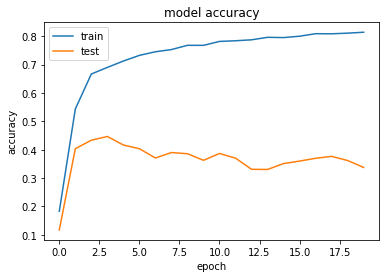

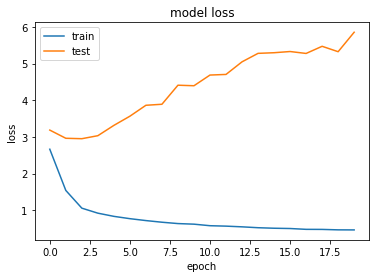

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
score = model.evaluate(test_data, test_target)

  32/4974 [..............................] - ETA: 0s

 512/4974 [==>...........................] - ETA: 0s

1216/4974 [======>.......................] - ETA: 0s

1888/4974 [==========>...................] - ETA: 0s

2656/4974 [===============>..............] - ETA: 0s

3328/4974 [===================>..........] - ETA: 0s

3872/4974 [======================>.......] - ETA: 0s

4384/4974 [=========================>....] - ETA: 0s

4928/4974 [============================>.] - ETA: 0s

4974/4974 [==============================] - 0s 85us/step


In [21]:
test_y = model.predict(test_data)
test_y = np.argmax(test_y, axis=1)
test_t = np.argmax(test_target, axis=1)
print(test_t.shape, test_y.shape)
acc = evaluate_vec(test_y, test_t).tolist()

print(format(acc.count(1) / len(acc), '.6f'), format(np.mean(acc), '.6f'))

(4974,) (4974,)
0.420989 0.492883
